In [1]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.resnet import ResNet50
from keras.applications import VGG16
from tensorboard import notebook
from tensorflow import keras 
from tensorflow.keras.applications.resnet import ResNet50
import tensorflow as tf
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory

2025-04-10 12:36:48.068313: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


100%|██████████| 186/186 [00:01<00:00, 115.12it/s]


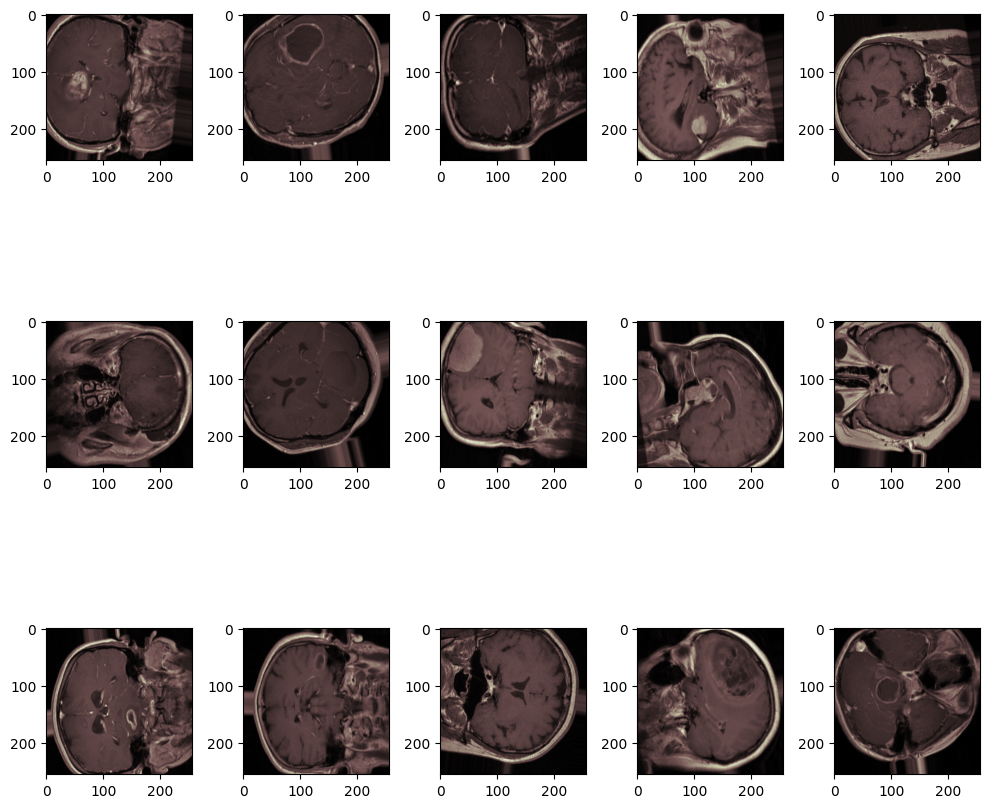

(614, 256, 256, 3)
(10534, 256, 256, 3)
(614, 3)
(10534, 3)


In [2]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 256
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [30]:
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    ReLU,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Concatenate,
    GlobalMaxPooling2D,
    Dropout,
    Dense,
    Lambda,
    Reshape,
    Activation,
    Multiply,
    UpSampling2D,
    Add
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


def GSB(inputs):
    
    b, h, w, c = inputs.shape.as_list()
    
    # Spatial attention branch
    a = Conv2D(c // 8, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(inputs)
    a = Activation('sigmoid')(a)
    a = GlobalAveragePooling2D()(a)
    
    a = tf.reshape(a, [-1, 1, c // 8])
   
    # Channel attention branch
    b_tensor = Conv2D(c // 8, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(inputs)
    b_tensor = Activation('sigmoid')(b_tensor)
    b_tensor = tf.reshape(b_tensor, [-1, c // 8, h*w])
    
    # First interaction
    inter = K.batch_dot(a, b_tensor)
    
    inter = Activation('softmax')(inter)
    outer = tf.reshape(inter, [-1, h, w, 1])
    
    # Second channel branch
    c_tensor = Conv2D(c // 8, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(inputs)
    c_tensor = Activation('sigmoid')(c_tensor)
    c_tensor = tf.reshape(c_tensor, [-1, h*w, c // 8])
    
    # Second interaction
    inter = K.batch_dot(inter, c_tensor)
    inter = tf.reshape(inter, [-1, 1, 1, c // 8])  # Reshape to match the broadcasting
    inter = Conv2D(c, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(inter)
    inter = Activation('sigmoid')(inter)
    
    # Final weighting
    w1 = Multiply()([outer, inputs])
    
    w2 = Multiply()([inter, inputs])
    
    x = Add()([w1, w2])
    
    return x



def load_model():
    
    K.clear_session()
    inputs = Input(shape=(image_size, image_size, 3))
    

    # Create ResNet50 with the correct input
    base_model = ResNet50(weights=None, include_top=False, input_tensor=inputs)
    
    x = base_model.output

    shape = x.shape
    x1 = GSB(x)
    x1 = Conv2D(shape[3] // 4, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x1)
    x2 = GSB(x)
    x2 = Conv2D(shape[3] // 4, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x2)
    x3 = GSB(x)
    x3 = Conv2D(shape[3] // 4, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x3)
    x4 = GSB(x)
    x4 = Conv2D(shape[3] // 4, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x4)

    x = Concatenate()([x1, x2, x3, x4])
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    
    return model

In [31]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [32]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-GTNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

Epoch 1/50
297/297 [==============================] - ETA: 0s - loss: 1.1306 - accuracy: 0.5473
Epoch 1: val_accuracy improved from -inf to 0.33207, saving model to model-GTNet.h5
Epoch 1: 47.99 seconds
297/297 [==============================] - 48s 127ms/step - loss: 1.1306 - accuracy: 0.5473 - val_loss: 3.1100 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
297/297 [==============================] - ETA: 0s - loss: 0.6297 - accuracy: 0.7667
Epoch 2: val_accuracy improved from 0.33207 to 0.42220, saving model to model-GTNet.h5
Epoch 2: 34.20 seconds
297/297 [==============================] - 34s 115ms/step - loss: 0.6297 - accuracy: 0.7667 - val_loss: 6.2777 - val_accuracy: 0.4222 - lr: 1.0000e-04
Epoch 3/50
296/297 [============================>.] - ETA: 0s - loss: 0.4163 - accuracy: 0.8445
Epoch 3: val_accuracy did not improve from 0.42220
Epoch 3: 31.29 seconds
297/297 [==============================] - 31s 105ms/step - loss: 0.4172 - accuracy: 0.8442 - val_loss: 9.1292 - val_ac

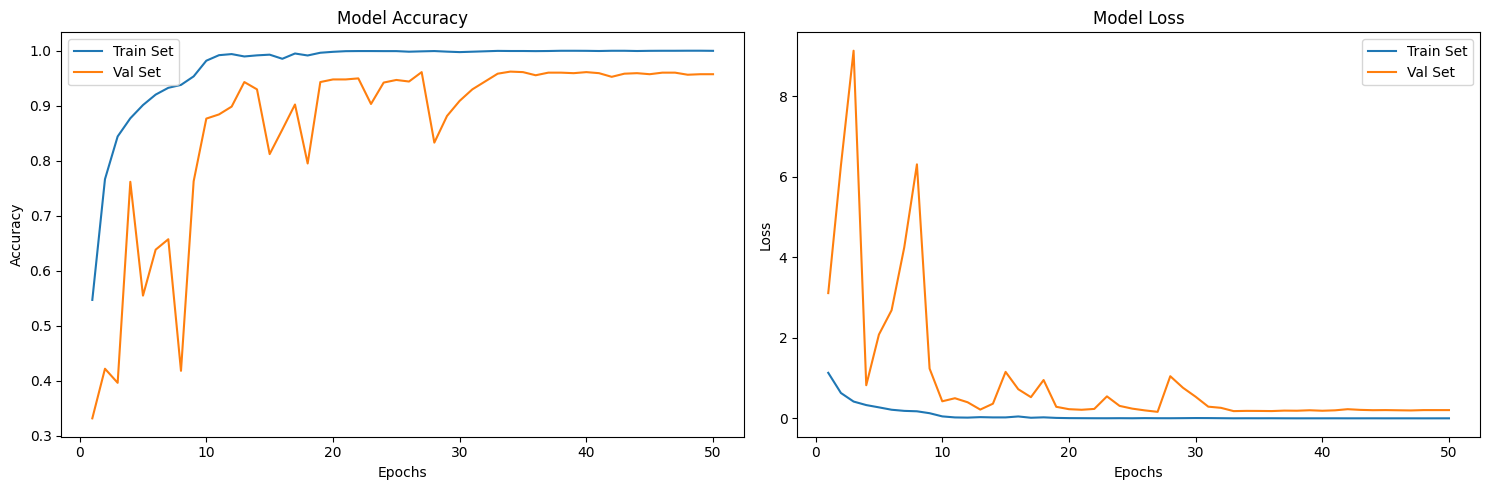

20/20 [==============================] - 1s 29ms/step - loss: 0.2078 - accuracy: 0.9593
Test Accuracy:  95.93
              precision    recall  f1-score   support

      glioma     0.9756    0.9790    0.9773       286
  meningioma     0.9281    0.9085    0.9181       142
   pituitary     0.9574    0.9677    0.9626       186

    accuracy                         0.9593       614
   macro avg     0.9537    0.9517    0.9527       614
weighted avg     0.9591    0.9593    0.9592       614



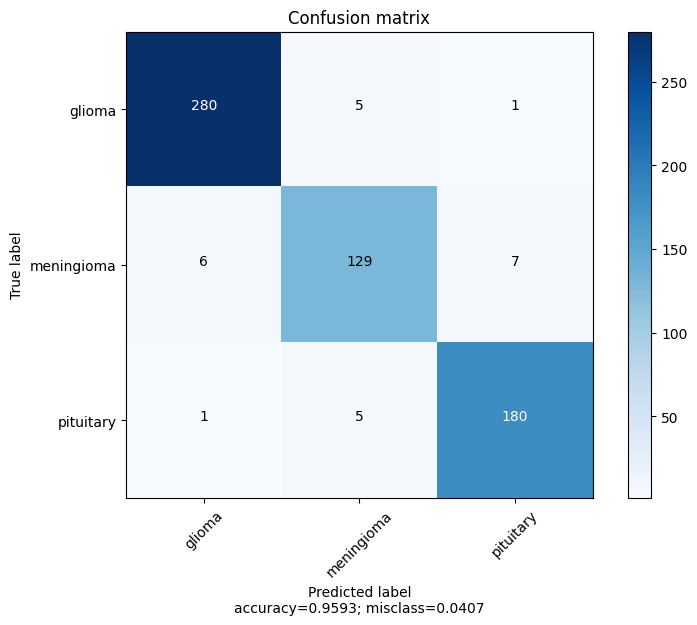

In [33]:
draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

Epoch 1/50
297/297 [==============================] - ETA: 0s - loss: 1.1259 - accuracy: 0.5560
Epoch 1: val_accuracy improved from -inf to 0.33207, saving model to model-GTNet.h5
Epoch 1: 36.88 seconds
297/297 [==============================] - 37s 104ms/step - loss: 1.1259 - accuracy: 0.5560 - val_loss: 3.9126 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
297/297 [==============================] - ETA: 0s - loss: 0.6458 - accuracy: 0.7593
Epoch 2: val_accuracy improved from 0.33207 to 0.36528, saving model to model-GTNet.h5
Epoch 2: 28.23 seconds
297/297 [==============================] - 28s 95ms/step - loss: 0.6458 - accuracy: 0.7593 - val_loss: 4.4426 - val_accuracy: 0.3653 - lr: 1.0000e-04
Epoch 3/50
297/297 [==============================] - ETA: 0s - loss: 0.4208 - accuracy: 0.8410
Epoch 3: val_accuracy improved from 0.36528 to 0.37381, saving model to model-GTNet.h5
Epoch 3: 30.52 seconds
297/297 [==============================] - 31s 103ms/step - loss: 0.4208 - accuracy:

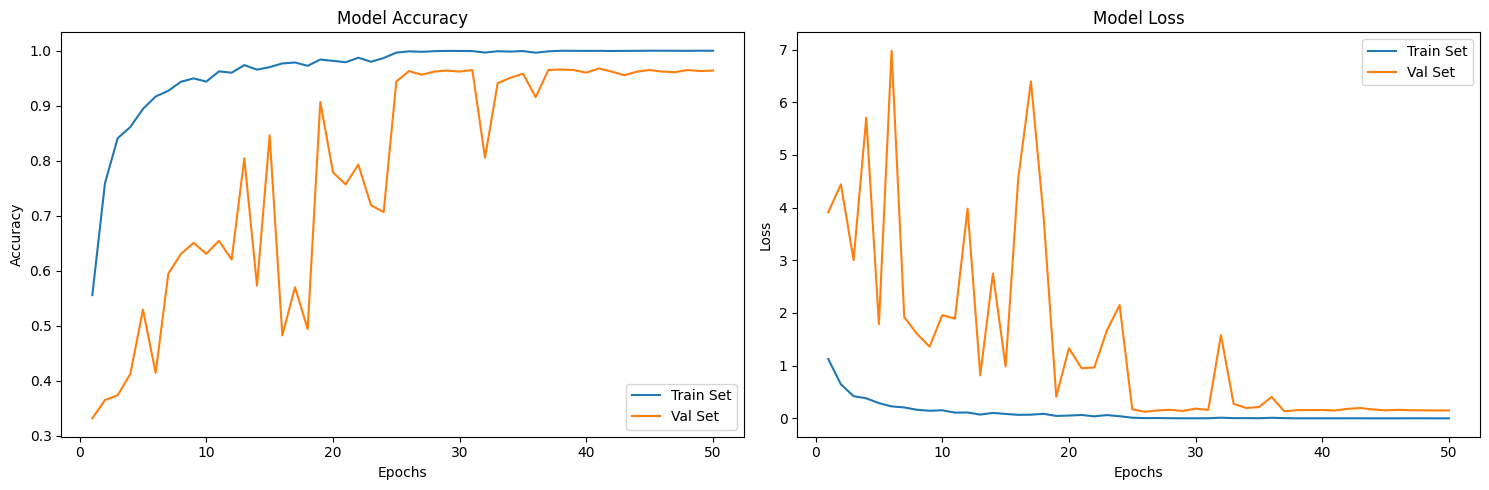

20/20 [==============================] - 1s 31ms/step - loss: 0.1565 - accuracy: 0.9674
Test Accuracy:  96.74
              precision    recall  f1-score   support

      glioma     0.9788    0.9685    0.9736       286
  meningioma     0.9241    0.9437    0.9338       142
   pituitary     0.9839    0.9839    0.9839       186

    accuracy                         0.9674       614
   macro avg     0.9623    0.9654    0.9638       614
weighted avg     0.9677    0.9674    0.9675       614



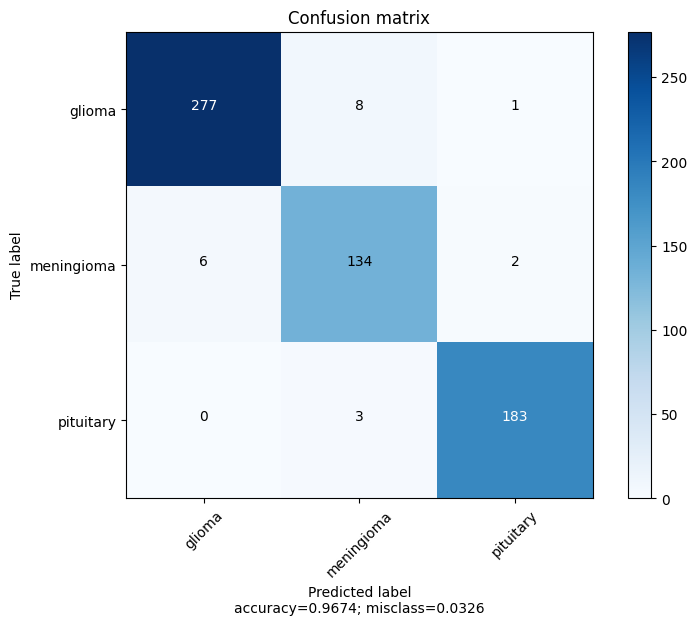

In [34]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-GTNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

Epoch 1/50
297/297 [==============================] - ETA: 0s - loss: 1.1706 - accuracy: 0.5445
Epoch 1: val_accuracy improved from -inf to 0.38425, saving model to model-GTNet.h5
Epoch 1: 42.16 seconds
297/297 [==============================] - 42s 118ms/step - loss: 1.1706 - accuracy: 0.5445 - val_loss: 2.7178 - val_accuracy: 0.3843 - lr: 1.0000e-04
Epoch 2/50
297/297 [==============================] - ETA: 0s - loss: 0.6228 - accuracy: 0.7594
Epoch 2: val_accuracy improved from 0.38425 to 0.43454, saving model to model-GTNet.h5
Epoch 2: 27.98 seconds
297/297 [==============================] - 28s 94ms/step - loss: 0.6228 - accuracy: 0.7594 - val_loss: 3.9067 - val_accuracy: 0.4345 - lr: 1.0000e-04
Epoch 3/50
297/297 [==============================] - ETA: 0s - loss: 0.4596 - accuracy: 0.8258
Epoch 3: val_accuracy did not improve from 0.43454
Epoch 3: 26.85 seconds
297/297 [==============================] - 27s 90ms/step - loss: 0.4596 - accuracy: 0.8258 - val_loss: 3.3620 - val_accu

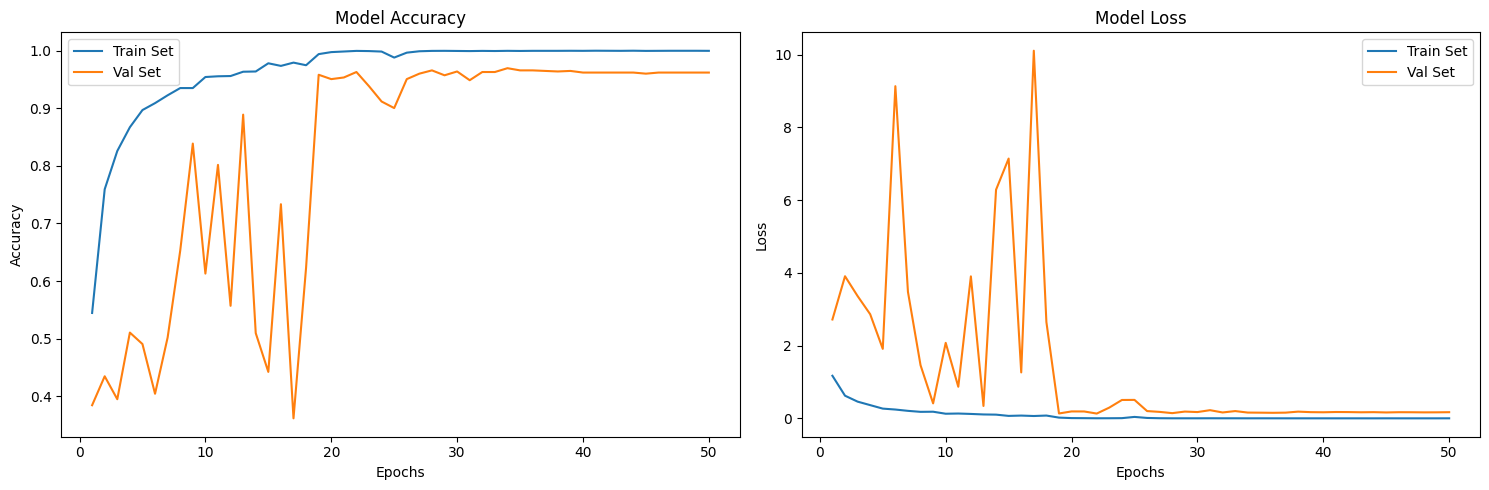

20/20 [==============================] - 1s 31ms/step - loss: 0.1726 - accuracy: 0.9609
Test Accuracy:  96.09
              precision    recall  f1-score   support

      glioma     0.9788    0.9685    0.9736       286
  meningioma     0.9172    0.9366    0.9268       142
   pituitary     0.9677    0.9677    0.9677       186

    accuracy                         0.9609       614
   macro avg     0.9546    0.9576    0.9561       614
weighted avg     0.9612    0.9609    0.9610       614



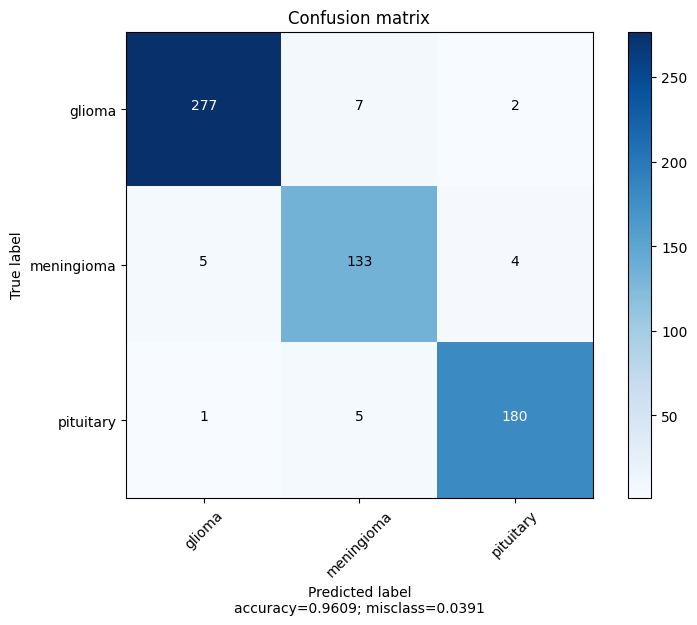

In [35]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-GTNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

Epoch 1/50
297/297 [==============================] - ETA: 0s - loss: 1.1722 - accuracy: 0.5412
Epoch 1: val_accuracy improved from -inf to 0.37571, saving model to model-GTNet.h5
Epoch 1: 41.51 seconds
297/297 [==============================] - 42s 117ms/step - loss: 1.1722 - accuracy: 0.5412 - val_loss: 3.3952 - val_accuracy: 0.3757 - lr: 1.0000e-04
Epoch 2/50
296/297 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.7300
Epoch 2: val_accuracy improved from 0.37571 to 0.49620, saving model to model-GTNet.h5
Epoch 2: 27.12 seconds
297/297 [==============================] - 27s 91ms/step - loss: 0.6934 - accuracy: 0.7300 - val_loss: 4.5622 - val_accuracy: 0.4962 - lr: 1.0000e-04
Epoch 3/50
297/297 [==============================] - ETA: 0s - loss: 0.4547 - accuracy: 0.8264
Epoch 3: val_accuracy did not improve from 0.49620
Epoch 3: 27.76 seconds
297/297 [==============================] - 28s 94ms/step - loss: 0.4547 - accuracy: 0.8264 - val_loss: 5.2352 - val_accu

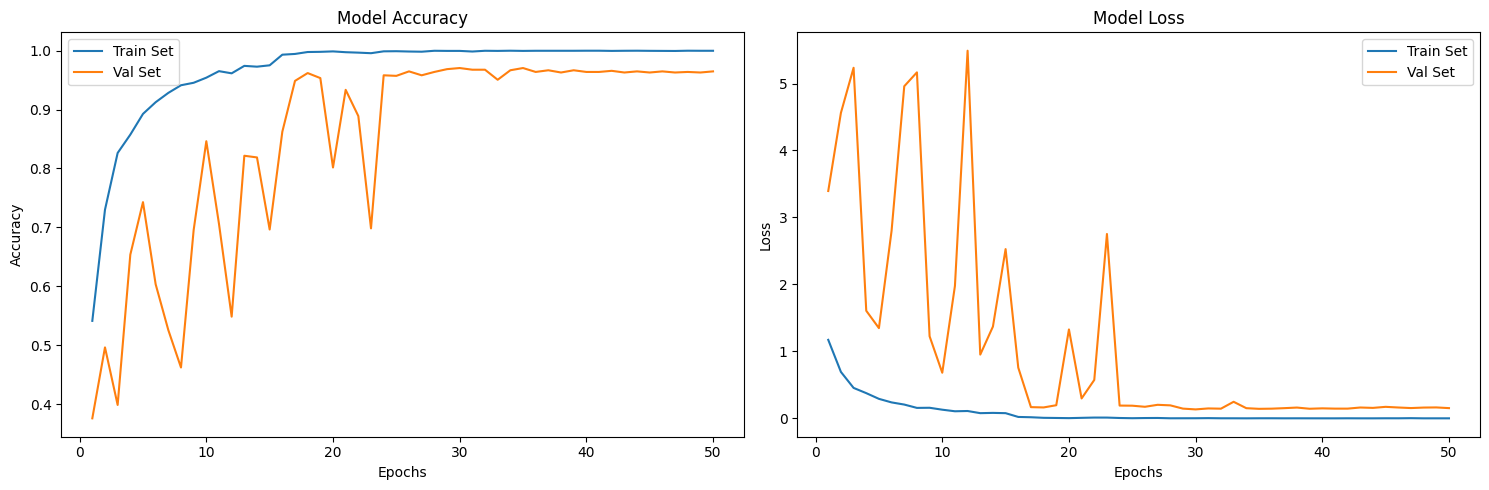

20/20 [==============================] - 1s 31ms/step - loss: 0.1991 - accuracy: 0.9577
Test Accuracy:  95.77
              precision    recall  f1-score   support

      glioma     0.9688    0.9755    0.9721       286
  meningioma     0.9338    0.8944    0.9137       142
   pituitary     0.9579    0.9785    0.9681       186

    accuracy                         0.9577       614
   macro avg     0.9535    0.9495    0.9513       614
weighted avg     0.9574    0.9577    0.9574       614



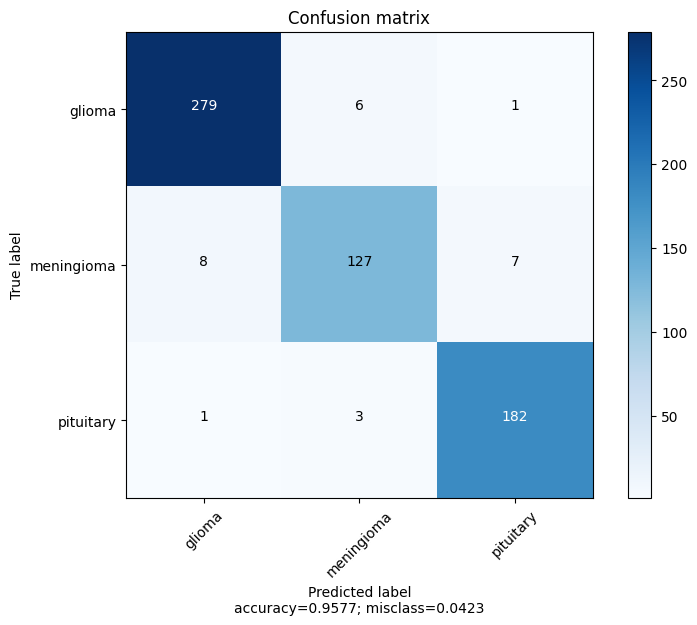

In [36]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-GTNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

Epoch 1/50
296/297 [============================>.] - ETA: 0s - loss: 1.1131 - accuracy: 0.5670
Epoch 1: val_accuracy improved from -inf to 0.38425, saving model to model-GTNet.h5
Epoch 1: 38.98 seconds
297/297 [==============================] - 39s 105ms/step - loss: 1.1128 - accuracy: 0.5672 - val_loss: 4.5408 - val_accuracy: 0.3843 - lr: 1.0000e-04
Epoch 2/50
297/297 [==============================] - ETA: 0s - loss: 0.6131 - accuracy: 0.7787
Epoch 2: val_accuracy improved from 0.38425 to 0.45351, saving model to model-GTNet.h5
Epoch 2: 29.05 seconds
297/297 [==============================] - 29s 98ms/step - loss: 0.6131 - accuracy: 0.7787 - val_loss: 8.7595 - val_accuracy: 0.4535 - lr: 1.0000e-04
Epoch 3/50
297/297 [==============================] - ETA: 0s - loss: 0.4052 - accuracy: 0.8498
Epoch 3: val_accuracy improved from 0.45351 to 0.63378, saving model to model-GTNet.h5
Epoch 3: 27.59 seconds
297/297 [==============================] - 28s 93ms/step - loss: 0.4052 - accuracy: 

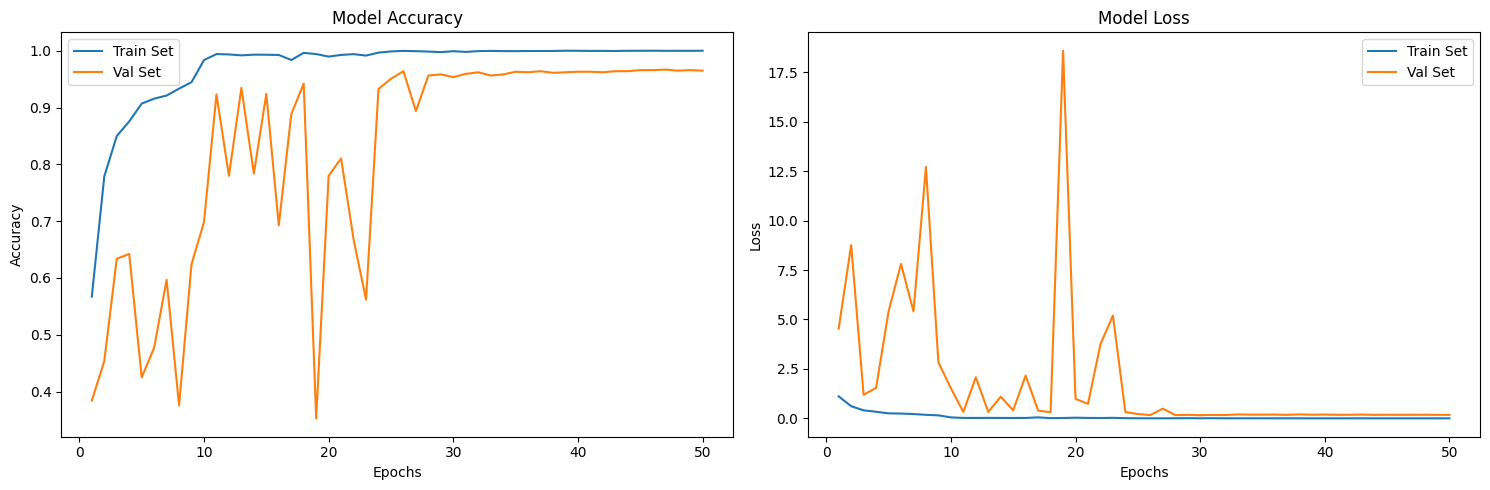

20/20 [==============================] - 1s 30ms/step - loss: 0.1510 - accuracy: 0.9544
Test Accuracy:  95.44
              precision    recall  f1-score   support

      glioma     0.9752    0.9615    0.9683       286
  meningioma     0.8926    0.9366    0.9141       142
   pituitary     0.9727    0.9570    0.9648       186

    accuracy                         0.9544       614
   macro avg     0.9468    0.9517    0.9491       614
weighted avg     0.9553    0.9544    0.9547       614



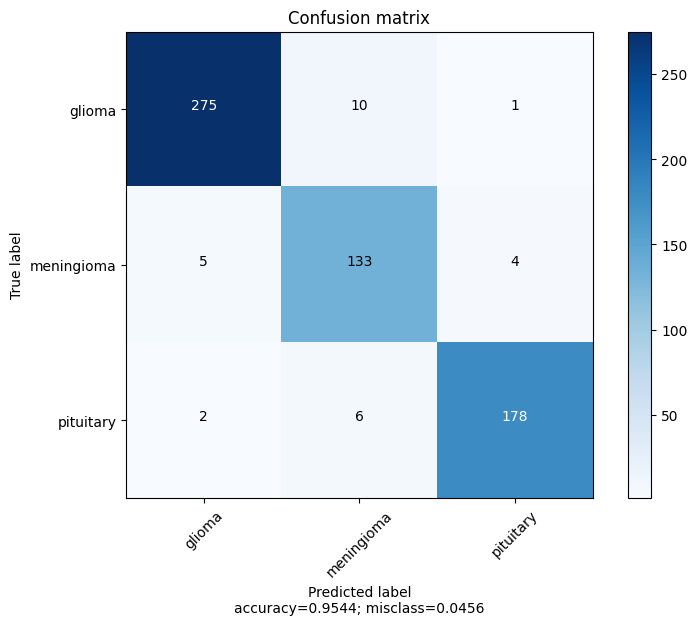

In [37]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-GTNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)